In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr
logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

from plot_utils import plot_ground_truth_heatmap, plot_spike_grps
from sim_utils import load_regime_results, get_sim_params
from sim_utils import generate_regime_info, get_regime_info

fig_dir = '/scratch/PI/sabatti/spatial_subplots/'

In [3]:
# umap embedding?

In [4]:
import networkx as nx

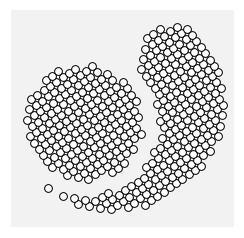

In [93]:
import itertools

def rotate_coord(df_all, angle=325):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    rot_coord = np.matmul(df_all[['x', 'y']].values, R)
    df_all['x'] = rot_coord[:, 0]
    df_all['y'] = rot_coord[:, 1]
    if angle == 325:
        df_all['y'] = df_all['y'] + 0.15
        df_all['x'] = df_all['x'] - 0.08
    return df_all

def common_config(ax):
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_facecolor('#f2f2f2')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
def trace_magatama(df, cut_pos):
    keep = (np.square(df['x']) + np.square(df['y'])) < 1
    df = df.loc[keep]
    # drop part 1
    rrad = (1 - cut_pos) / 2
    drop = ((df['x'] > cut_pos) & (df['y'] > 0) & 
           ((np.square(df['x']-cut_pos-rrad) + np.square(df['y'])) > rrad**2))
    df = df[-drop]
    # drop part_2
    drop = ((df['x'] < cut_pos) & (df['y'] > 0))
    df = df[-drop]
    # drop part 3
    rrad = (1 + cut_pos) / 2
    drop = ((df['x'] < cut_pos) & 
            ((np.square(df['x']-cut_pos+rrad) + np.square(df['y'])) < rrad**2))
    df = df[-drop]
    return df

def trace_circle(df2, cut_pos, gap=0.15):
    rrad = (1 + cut_pos) / 2
    x_cent = cut_pos-rrad
    keep = ((np.square(df2['x']-cut_pos+rrad) + np.square(df2['y'])) < (rrad-gap)**2)
    df2 = df2[keep]
    return df2

       
n_ticks = 30
cut_pos = 0.35
rotate = True
coord = list(itertools.product(range(n_ticks), range(n_ticks)))
df = pd.DataFrame(coord, columns=['x', 'y'])
df = df / (n_ticks-1) *2 - 1 
df2 = trace_circle(df.copy(), cut_pos)
df1 = trace_magatama(df.copy(), cut_pos)

if rotate:
    df1 = rotate_coord(df1)
    df2 = rotate_coord(df2)

df_all = pd.concat([df1, df2]).reset_index()

# plot the coordinates
fig, ax = plt.subplots(1,1,figsize=(4,4))
df_all.plot.scatter(x='x',y='y', ax=ax, s=60,
                    c='white', edgecolor='black')
common_config(ax)
plt.show()

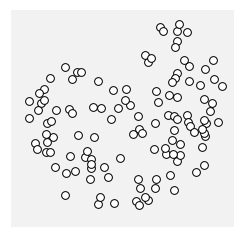

In [95]:
np.random.seed(10)
df_use = df_all.sample(120)
z = np.array(df_use[['x', 'y']])
z = z + np.random.normal(size=z.shape)*0.02
df_use['x'] = z[:, 0]
df_use['y'] = z[:, 1]
fig, ax = plt.subplots(1,1,figsize=(4,4))
df_use.plot.scatter(x='x',y='y', ax=ax, s=60,
                    c='white', edgecolor='black')
common_config(ax)
plt.show()

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


(-1.5, 1.5, -1.5, 1.5)

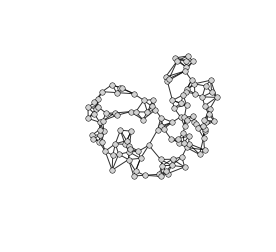

In [96]:
pos = {}
for i in range(z.shape[0]):
    pos[i] = z[i, :]

from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(z, n_neighbors=4)
G = nx.from_numpy_array(A.toarray())

fig, ax = plt.subplots(1,1,figsize=(4,4))
nx.draw_networkx_edges(G,pos, alpha=0.8, ax=ax)
nx.draw_networkx_nodes(G,pos, 
                       ax=ax, 
                       node_size=30, 
                       edgecolors='black',
                       linewidths=0.5,
                       node_color='lightgrey')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
fn = (fig_dir+'new_sge_graph.pdf')
plt.savefig(fn, bbox_inches='tight') 
plt.axis('off')

['g0', 'g1', 'g2', 'g3']
saved: /scratch/PI/sabatti/spatial_subplots/sge_img.pdf


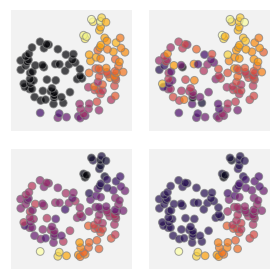

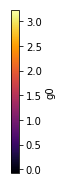

In [80]:
gg = ['g{}'.format(i) for i in range(4)]
print(gg)

def sim_expr(df, dtype):
    n = df.shape[0]
    if dtype == 'high':
        val = 4 + 1/2*np.random.normal(size=n)
    elif dtype == 'low':
        val = 2 + 1/2*np.random.normal(size=n)
    elif dtype == 'med':
        val = 2 + 0.8*np.random.normal(size=n)
    elif dtype == 'right':
        val = np.arctan2(df['y'], df['x']) + 3
        val = val + 1/4*np.random.normal(size=n)
#     elif dtype == 'middle':    
    elif dtype == 'left':  
        val = -np.arctan2(df['y'], df['x']) *2 + 2
        val = val + 1/4*np.random.normal(size=n)
    else: # dtype == 'zero':
        val = np.zeros(n)
    return val

def gen_expr(df1, df2, patterns, names):
    plist = []
    for t1, t2 in patterns:
        e1 = sim_expr(df1, t1)
        e2 = sim_expr(df2, t2)
        es = np.concatenate([e1,e2])
        plist.append(es)
    out = np.array(plist).T
    df = pd.DataFrame(out, columns=names)
    return df

def plot_fish_fig(df_plt, cols, fn=None):
    fig, axes = plt.subplots(2, 2, figsize=(4,4))
    for i in range(2):
        for j in range(2):
            col = cols[i * 2 + j]
            ax = axes[i][j]
            df_plt.plot.scatter(x='x',y='y', c=col, ax=ax, 
                                s=60, edgecolor='grey', alpha=0.7,
                                colormap='inferno', colorbar=False)
            common_config(ax)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight') 
        print('saved: {}'.format(fn))
    plt.show()
    
p1 = [('zero', 'med'), 
      ('low', 'high'), 
      ('med', 'zero'),
      ('high', 'low')]
p2 = [('right', 'zero'), 
      ('right', 'med'), 
      ('left', 'low'),
      ('left', 'zero')]
df_g1 = gen_expr(df1, df2, p1, gg)
df_g1 = pd.concat([df_use, df_g1], axis=1)
df_g2 = gen_expr(df1, df2, p2, gg)
df_g2 = pd.concat([df_use, df_g2], axis=1)

plot_fish_fig(df_g2, gg, fn=(fig_dir+'sge_img.pdf'))
# plot_fish_fig(df_g1, gg, fn=(fig_dir+'cell_type.pdf'))
# plot_fish_fig(df_g2, gg, fn=(fig_dir+'cell_state.pdf'))

def plot_axes(df_plt, col):
    fig, ax = plt.subplots(1, 1 ,figsize=(3,3))
    df_plt.plot.scatter(x='x',y='y', c=col, ax=ax, 
                        colormap='inferno')
    ax.remove()
    
    plt.show()
plot_axes(df_g1, 'g0')

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


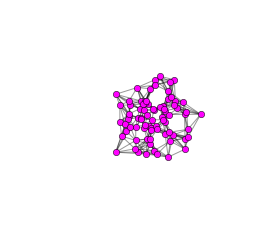

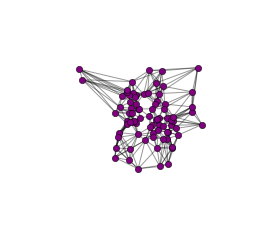

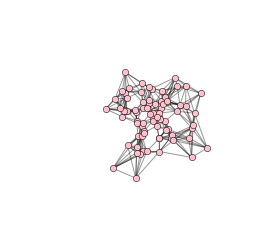

In [19]:
n_pts = 80
np.random.seed(19)

for col in ['magenta', 'purple', 'pink']:
    scale = 0.3
    theta = np.linspace(0, np.pi, n_pts)
    x = np.random.normal(size=len(theta))*scale
    y = np.random.normal(size=len(theta))*scale
    z = np.array([x,y]).T
    
    theta = np.radians(240)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    pos = {}
    for i in range(n_pts):
        coord = np.array([-x[i], y[i]])
        coord = np.matmul(coord, R)
        pos[i] = coord

    from sklearn.neighbors import kneighbors_graph
    A = kneighbors_graph(z, n_neighbors=8)
    G = nx.from_numpy_array(A.toarray())

    fig, ax = plt.subplots(1,1,figsize=(4,4))
    nx.draw_networkx_edges(G,pos,alpha=0.4, ax=ax)
    nx.draw_networkx_nodes(G,pos, 
                           ax=ax, 
                           node_size=40, 
                           edgecolors='black',
                           linewidths=0.5,
                           node_color=col,
                           cmap='OrRd')
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    plt.axis('off')

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Saved: /scratch/PI/sabatti/spatial_subplots/network_update.pdf


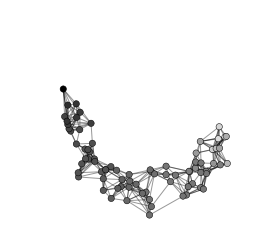

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Saved: /scratch/PI/sabatti/spatial_subplots/network_init.pdf


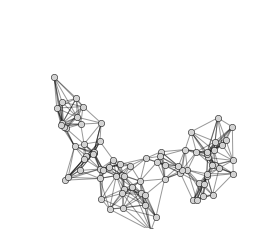

In [79]:
def plot_sample_network(n_pts=80, scale=0.15, fn=None, no_col=False):
    
    np.random.seed(19)
    theta = np.linspace(0, np.pi, n_pts)
    
    x = np.cos(theta) + np.random.normal(size=len(theta))*scale
    y = np.sin(theta) + np.random.normal(size=len(theta))*scale
    z = np.array([x,y]).T
    # fig, ax = plt.subplots(1,1,figsize=(4,4))
    # ax.scatter(*z.T)
    # ax.set_xlim(-1.5,1.5)
    # ax.set_ylim(-1.5,1.5)
    # plt.show()
    theta = np.radians(190)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    pos = {}
    for i in range(n_pts):
        coord = np.array([-x[i], y[i]])
        coord = np.matmul(coord, R)
        pos[i] = coord

    from sklearn.neighbors import kneighbors_graph
    A = kneighbors_graph(z, n_neighbors=8)
    G = nx.from_numpy_array(A.toarray())

    spec = nx.linalg.spectrum.laplacian_spectrum(G)
    spec[np.argmin(spec)] = np.min(spec)-3
    spec[np.argmax(spec)] = np.max(spec)+3

    fig, ax = plt.subplots(1,1,figsize=(4,4))
    nx.draw_networkx_edges(G,pos,alpha=0.4, ax=ax)
    if no_col:
        node_color = 'lightgrey'
    else:
        node_color = spec
    nx.draw_networkx_nodes(G,pos, 
                           ax=ax, 
                           node_size=40, 
                           edgecolors='black',
                           linewidths=0.5,
                           node_color=node_color,
                           cmap='binary')
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    # fn = fig_dir + 'less_noisy_network.pdf'
    plt.axis('off')
    if fn:
        plt.savefig(fn, bbox_inches='tight') 
        print('Saved:', fn)
    plt.show()
plot_sample_network(n_pts=80, scale=0.15, fn=(fig_dir+'network_update.pdf'))
plot_sample_network(n_pts=80, scale=0.25, fn=(fig_dir+'network_init.pdf'), no_col=True)

# Plot the Spatial Gene Expression

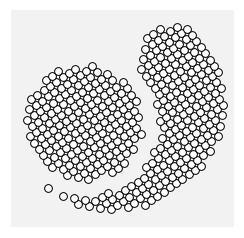

In [7]:
import itertools

def rotate_coord(df_all, angle=325):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    rot_coord = np.matmul(df_all[['x', 'y']].values, R)
    df_all['x'] = rot_coord[:, 0]
    df_all['y'] = rot_coord[:, 1]
    if angle == 325:
        df_all['y'] = df_all['y'] + 0.15
        df_all['x'] = df_all['x'] - 0.08
    return df_all

def common_config(ax):
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_facecolor('#f2f2f2')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
def trace_magatama(df, cut_pos):
    keep = (np.square(df['x']) + np.square(df['y'])) < 1
    df = df.loc[keep]
    # drop part 1
    rrad = (1 - cut_pos) / 2
    drop = ((df['x'] > cut_pos) & (df['y'] > 0) & 
           ((np.square(df['x']-cut_pos-rrad) + np.square(df['y'])) > rrad**2))
    df = df[-drop]
    # drop part_2
    drop = ((df['x'] < cut_pos) & (df['y'] > 0))
    df = df[-drop]
    # drop part 3
    rrad = (1 + cut_pos) / 2
    drop = ((df['x'] < cut_pos) & 
            ((np.square(df['x']-cut_pos+rrad) + np.square(df['y'])) < rrad**2))
    df = df[-drop]
    return df

def trace_circle(df2, cut_pos, gap=0.15):
    rrad = (1 + cut_pos) / 2
    x_cent = cut_pos-rrad
    keep = ((np.square(df2['x']-cut_pos+rrad) + np.square(df2['y'])) < (rrad-gap)**2)
    df2 = df2[keep]
    return df2

       
n_ticks = 30
cut_pos = 0.35
rotate = True
coord = list(itertools.product(range(n_ticks), range(n_ticks)))
df = pd.DataFrame(coord, columns=['x', 'y'])
df = df / (n_ticks-1) *2 - 1 
df2 = trace_circle(df.copy(), cut_pos)
df1 = trace_magatama(df.copy(), cut_pos)

if rotate:
    df1 = rotate_coord(df1)
    df2 = rotate_coord(df2)

df_all = pd.concat([df1, df2]).reset_index()

# plot the coordinates
fig, ax = plt.subplots(1,1,figsize=(4,4))
df_all.plot.scatter(x='x',y='y', ax=ax, s=60,
                    c='white', edgecolor='black')
common_config(ax)
plt.show()

In [14]:
def oval_shape(df, angle, off_x, off_y, scale=1):
    df['x'] = 0.2*(np.random.normal(size=df['x'].shape))*scale
    df['y'] = 0.4*(np.random.normal(size=df['y'].shape))*scale
    df = rotate_coord(df, angle=angle)
    df['x'] = df['x'] + off_x
    df['y'] = df['y'] + off_y
    return df
n_pts = 200
df1 = pd.DataFrame(np.zeros((n_pts,2)), columns=['x', 'y'])
df1 = oval_shape(df1, 90, 0.5, 1.2, scale=0.9)
n_pts = 500
df2 = pd.DataFrame(np.zeros((n_pts,2)), columns=['x', 'y'])
df2 = oval_shape(df2, -50, -0.3, -0.8, scale=1.2)
labels = [0] * df1.shape[0] + [1] * df2.shape[0]
df_all = pd.concat([df1,df2]).reset_index()
df_all['label'] = labels

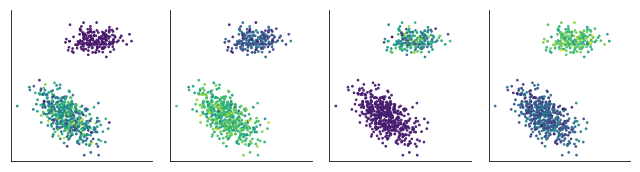

In [24]:
def cmon_ax(ax):
    ax.set_xlim(-1.8,2)
    ax.set_ylim(-2,2)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

p1 = [('zero', 'med'), 
      ('low', 'high'), 
      ('med', 'zero'),
      ('high', 'low')]
df_gg = gen_expr(df1, df2, p1, gg)
df_gg = pd.concat([df_all, df_gg], axis=1)
cols = gg
fig, axes = plt.subplots(1, len(p1), figsize=(9,2.5))
for i, col in enumerate(cols):
    ax = axes[i]
    df_gg.plot.scatter(x='x',y='y', c=col, ax=ax, alpha=0.9,
                        s=3, colormap='viridis', colorbar=False)
#     common_config(ax)
    cmon_ax(ax)
fn = fig_dir + 'gex_cell_types.pdf'
plt.savefig(fn, bbox_inches='tight') 
plt.tight_layout()
plt.show()

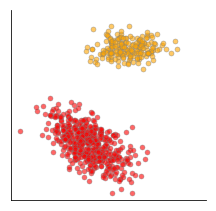

In [27]:
cols = ['orange', 'red']
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))
for i, df in enumerate([df1, df2]):
    ax.scatter(x=df['x'], y=df['y'], c=cols[i],
               s=25, alpha=0.6, edgecolor='grey', linewidth=0.6)
    cmon_ax(ax)
fn = fig_dir + 'gex_cell_annotation.pdf'
plt.savefig(fn, bbox_inches='tight') 
plt.show()

In [161]:
labels

['c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',
 'c1',

[feat_viz INFO] [60]
[feat_viz INFO] {'seed': 0, 'n_samps': 35, 'n_samps_list': [500, 1000, 1500, 2000, 5000], 'n_trials': 50, 'x_param': {'spike_grp': ['right', 'right', 'left', 'left'], 'n_repetitions': 1, 'rel_noise_list': [0.02]}, 'y_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r'], 'n_repetitions': 6, 'rel_noise_list': [0.05]}, 'target_vars': 60, 'method': None, 'graph_k': 10, 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_strict_1', 'n_var_list': [60]}


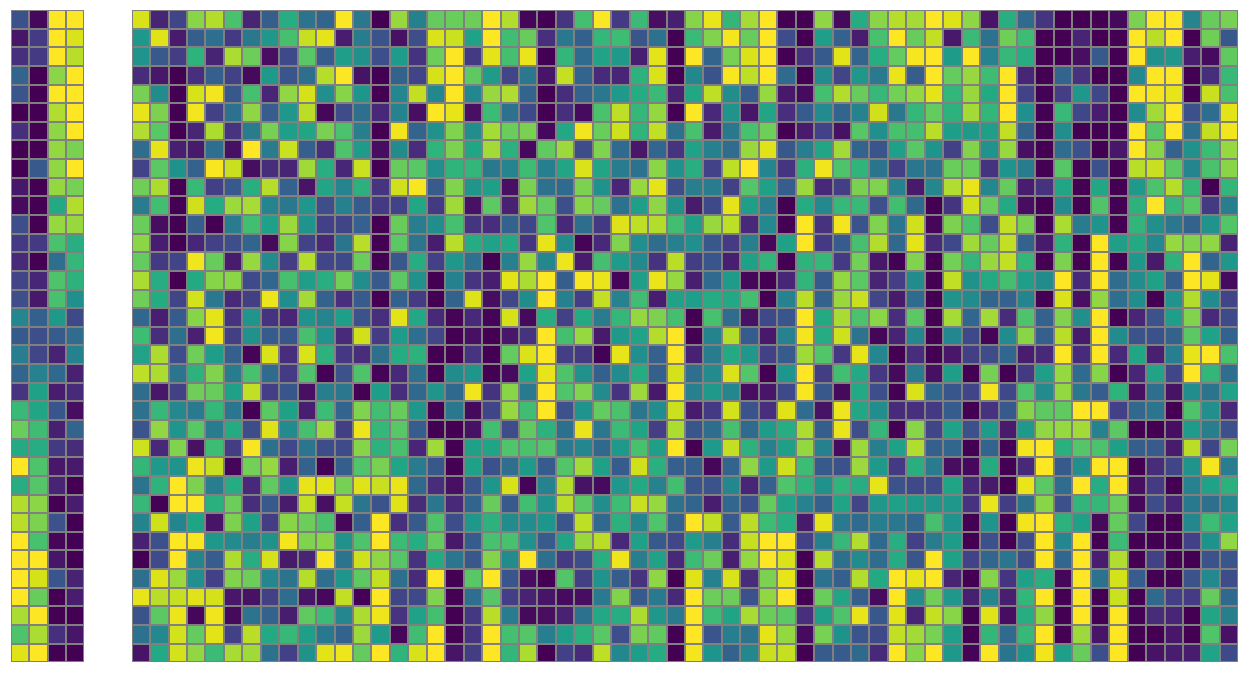

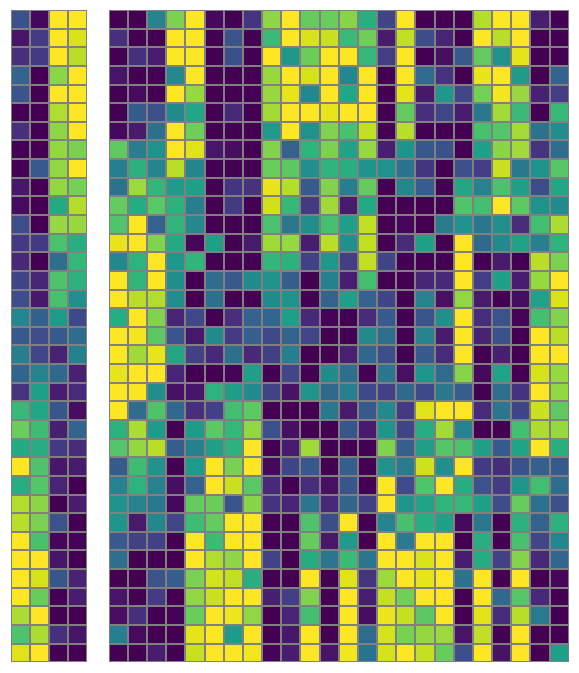

In [144]:
from sim_utils import generate_synthetic_data
from plot_utils import plot_main_example_figure
from plot_utils import plot_spikes_examples
from plot_utils import plot_base_heatmap
import matplotlib.gridspec as gridspec

sim_params = get_sim_params("main_sim_strict_1")
sim_params["n_samps"] = 35
sim_params["y_param"]["n_repetitions"] = 6
sim_params["x_param"]['spike_grp'] = [  'right', 'right', 'left', 'left']
sim_params["x_param"]['n_repetitions'] = 1
sim_params["x_param"]['rel_noise_list'] = [0.02]
sim_params["y_param"]['rel_noise_list'] = [5e-2]
sim_params["y_param"]['spike_grp'] = ['right', 'left', 'mid', 'mid_r']
sim_params['target_vars'] = 60
sim_params['n_var_list'] = [sim_params['target_vars']]
logger.info("{}".format(sim_params["n_var_list"]))

def plot_example_heatmap(sim_params, fn=None):
    lam, x_mtx, y_mtx, n_mtx = generate_synthetic_data(sim_params, linspace=True, sort=True)
    l_mtx = np.expand_dims(lam, axis=1)
    fig = plt.figure(figsize=(21, 12))
    width_ratios = [l_mtx.shape[1],
                    l_mtx.shape[1]*0.5,
                    x_mtx.shape[1], 
                    y_mtx.shape[1], 
                    n_mtx.shape[1]]
    gs00 = gridspec.GridSpec(1, len(width_ratios), 
                            figure=fig,
                            width_ratios=width_ratios,
                            wspace=0.08, hspace=0.2)
    ax = plt.subplot(gs00[0, 0])
    ax = plot_base_heatmap(l_mtx, ax=ax, cmap="OrRd")
    ax = plt.subplot(gs00[0, 2])
    ax = plot_base_heatmap(x_mtx, ax=ax) 
    ax = plt.subplot(gs00[0, 3])
    ax = plot_base_heatmap(y_mtx, ax=ax) 
    ax = plt.subplot(gs00[0, 4])
    ax = plot_base_heatmap(n_mtx, ax=ax) 
    if fn:
        save_figure(fn)
    else:
        plt.show()
    return

lam, x_mtx, y_mtx, n_mtx = generate_synthetic_data(sim_params, linspace=True, sort=True)
# plot_example_heatmap(sim_params)
np.random.seed(1)
m_mtx = np.concatenate([y_mtx, n_mtx], axis=1)# mixed matrix
m_mtx = m_mtx[:, np.random.permutation(np.arange(m_mtx.shape[1]))]
m_mtx.shape
fig = plt.figure(figsize=(22, 12))
width_ratios = [x_mtx.shape[1], 
                m_mtx.shape[1]]
gs00 = gridspec.GridSpec(1, len(width_ratios), 
                        figure=fig,
                        width_ratios=width_ratios,
                        wspace=0.08, hspace=0.2)
ax = plt.subplot(gs00[0, 0])
ax = plot_base_heatmap(x_mtx, ax=ax)
ax = plt.subplot(gs00[0, 1])
ax = plot_base_heatmap(m_mtx, ax=ax) 
# ax = plt.subplot(gs00[0, 3])
# ax = plot_base_heatmap(y_mtx, ax=ax) 
# ax = plt.subplot(gs00[0, 4])
# ax = plot_base_heatmap(n_mtx, ax=ax) 
plt.show()


yp_mtx = y_mtx[:, np.random.permutation(np.arange(y_mtx.shape[1]))]
fig = plt.figure(figsize=(10, 12))
width_ratios = [x_mtx.shape[1], 
                yp_mtx.shape[1]]
gs00 = gridspec.GridSpec(1, len(width_ratios), 
                        figure=fig,
                        width_ratios=width_ratios,
                        wspace=0.08, hspace=0.2)
ax = plt.subplot(gs00[0, 0])
ax = plot_base_heatmap(x_mtx, ax=ax)
ax = plt.subplot(gs00[0, 1])
ax = plot_base_heatmap(yp_mtx, ax=ax) 
# ax = plt.subplot(gs00[0, 3])
# ax = plot_base_heatmap(y_mtx, ax=ax) 
# ax = plt.subplot(gs00[0, 4])
# ax = plot_base_heatmap(n_mtx, ax=ax) 
plt.show()

[feat_viz INFO] [80]
[feat_viz INFO] {'seed': 0, 'n_samps': 60, 'n_samps_list': [500, 1000, 1500, 2000, 5000], 'n_trials': 50, 'x_param': {'spike_grp': ['right', 'right', 'left', 'left'], 'n_repetitions': 1, 'rel_noise_list': [0.02]}, 'y_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r'], 'n_repetitions': 6, 'rel_noise_list': [0.05]}, 'target_vars': 80, 'method': None, 'graph_k': 10, 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_strict_1', 'n_var_list': [80]}


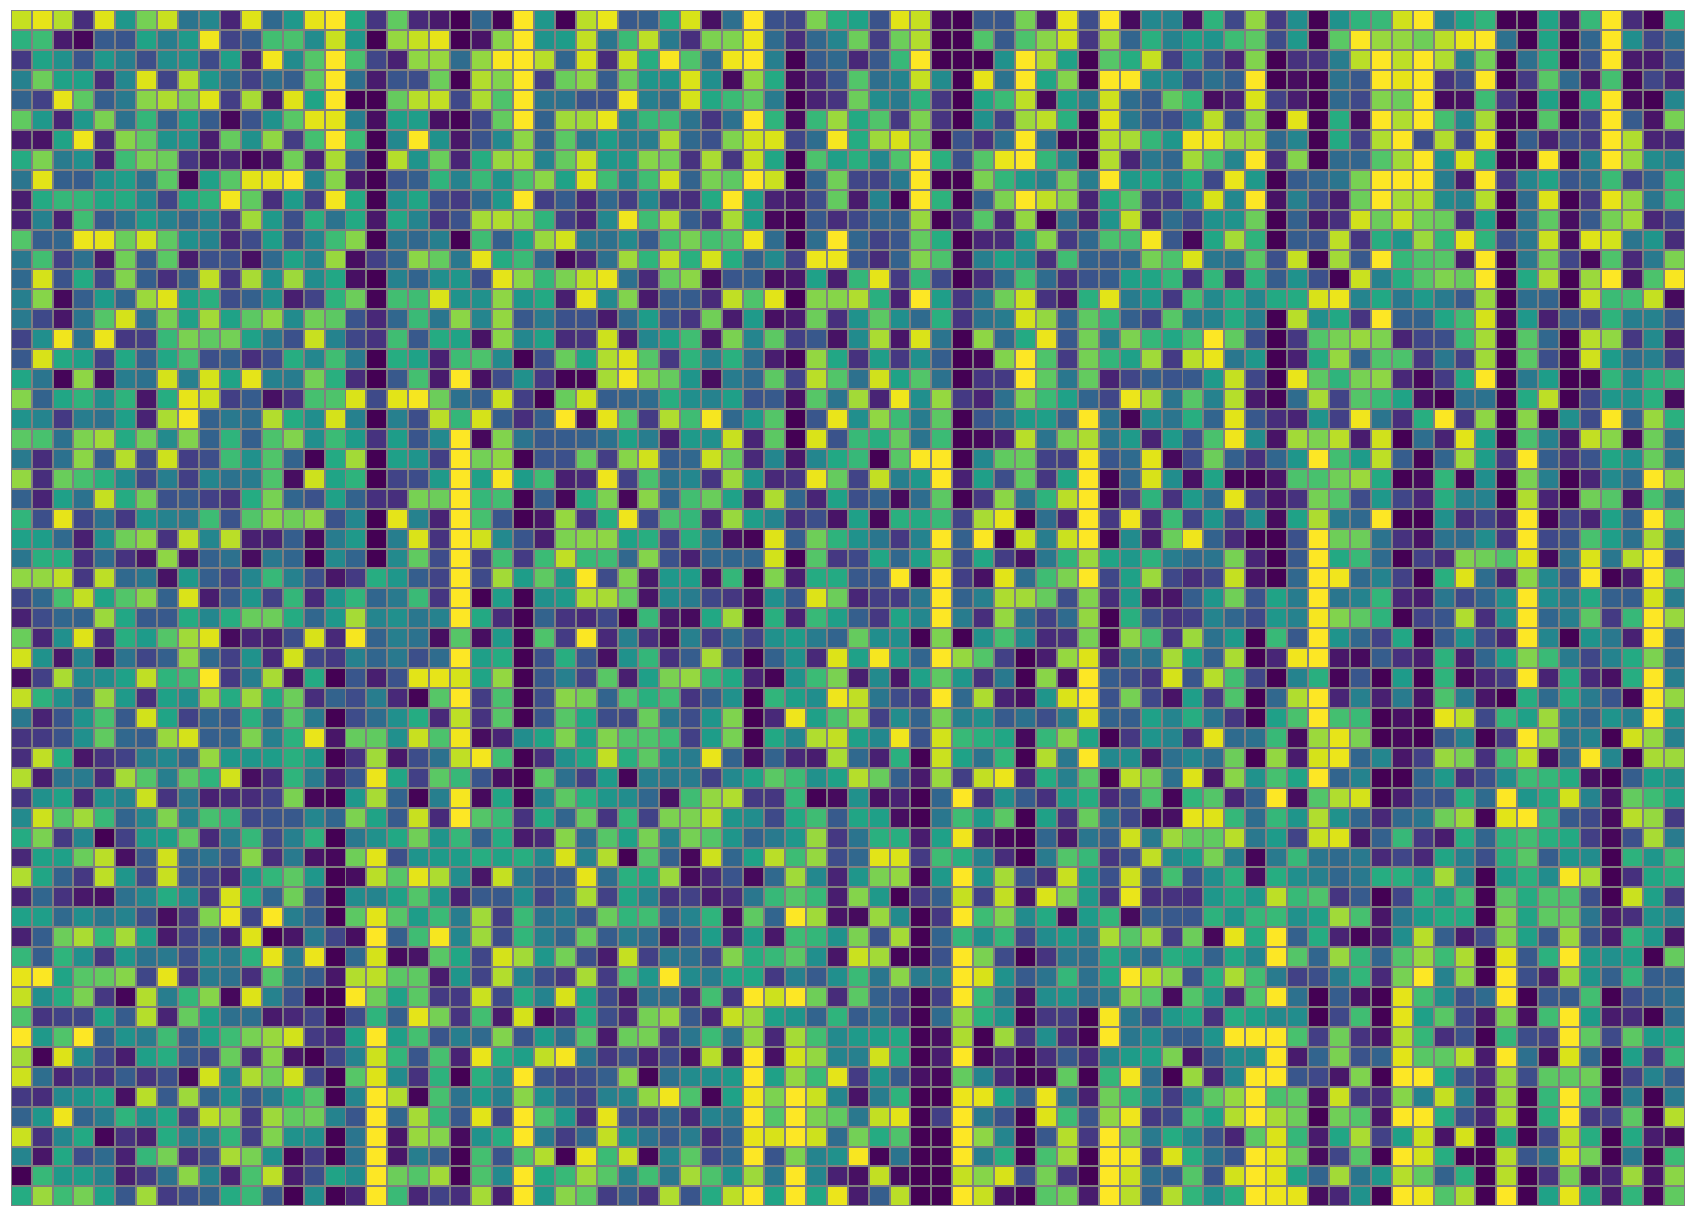

In [94]:
sim_params = get_sim_params("main_sim_strict_1")
sim_params["n_samps"] = 60
sim_params["y_param"]["n_repetitions"] = 6
sim_params["x_param"]['spike_grp'] = [  'right', 'right', 'left', 'left']
sim_params["x_param"]['n_repetitions'] = 1
sim_params["x_param"]['rel_noise_list'] = [0.02]
sim_params["y_param"]['rel_noise_list'] = [5e-2]
sim_params["y_param"]['spike_grp'] = ['right', 'left', 'mid', 'mid_r']
sim_params['target_vars'] = 80
sim_params['n_var_list'] = [sim_params['target_vars']]
logger.info("{}".format(sim_params["n_var_list"]))

lam, x_mtx, y_mtx, n_mtx = generate_synthetic_data(sim_params, linspace=True, sort=True)
# plot_example_heatmap(sim_params)
np.random.seed(1)
m_mtx = np.concatenate([y_mtx, n_mtx], axis=1)# mixed matrix
m_mtx = m_mtx[:, np.random.permutation(np.arange(m_mtx.shape[1]))]

fig, ax = plt.subplots(1,1,figsize=(30, 22))
ax = plot_base_heatmap(m_mtx, ax=ax)
plt.show()

[feat_viz INFO] {'seed': 0, 'n_samps': 35, 'n_samps_list': [500, 1000, 1500, 2000, 5000], 'n_trials': 50, 'x_param': {'spike_grp': ['right', 'right', 'left', 'left'], 'n_repetitions': 1, 'rel_noise_list': [0.02]}, 'y_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r'], 'n_repetitions': 6, 'rel_noise_list': [0.05]}, 'target_vars': 60, 'method': None, 'graph_k': 10, 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_strict_1', 'n_var_list': [60]}


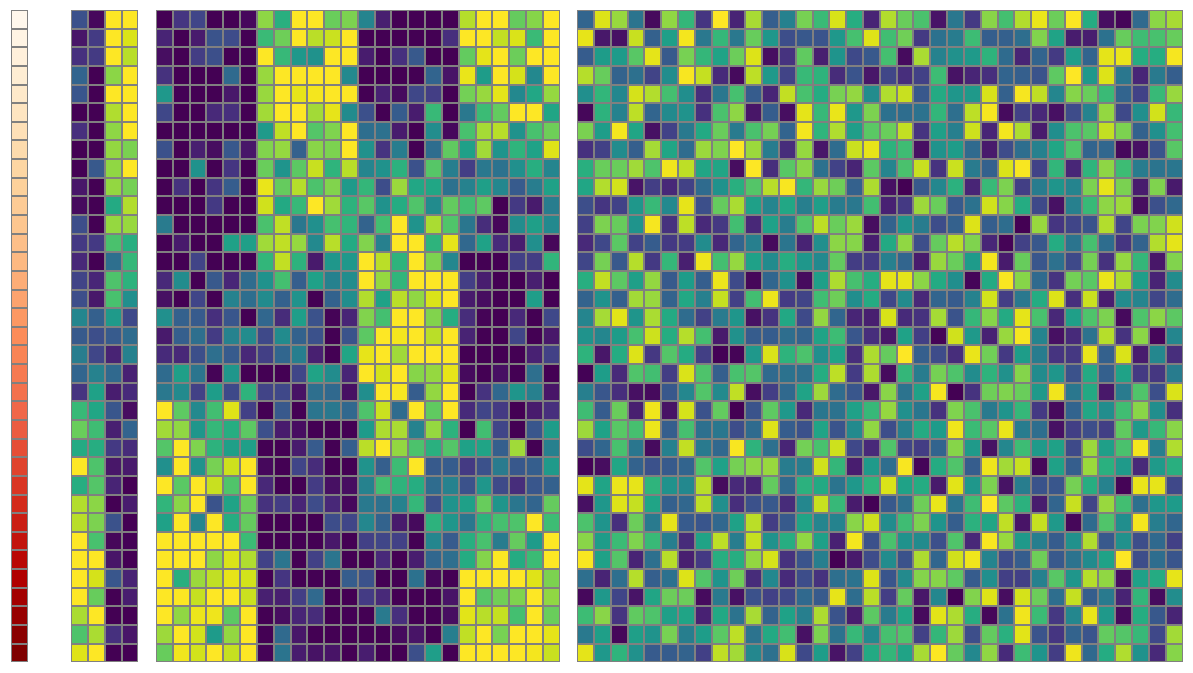

In [96]:
plot_example_heatmap(sim_params)

In [235]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.random_geometric_graph(200,0.125)
# position is stored as node attribute data for random_geometric_graph
pos=nx.get_node_attributes(G,'pos')

# find node near center (0.5,0.5)
dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

# color by path length from node near center
p=nx.single_source_shortest_path_length(G,ncenter)

In [ ]:
nnodes = 50


In [257]:
pos

{0: [0.7577015318797442, 0.6846302814963425],
 1: [0.6315117780653456, 0.17025075422239688],
 2: [0.9400977273093588, 0.35363010706483156],
 3: [0.6115483998837697, 0.28833936791826476],
 4: [0.5330918076267523, 0.8507998779647971],
 5: [0.21924462841938108, 0.6967105883561504],
 6: [0.7408338531981198, 0.03723115968563229],
 7: [0.32000388420949155, 0.34103729373952474],
 8: [0.4729763153536416, 0.4283909835677332],
 9: [0.7130936931310663, 0.7462496611982109],
 10: [0.3144039224701596, 0.8203044184924894],
 11: [0.42451268138065756, 0.7659299817949595],
 12: [0.04443507342451958, 0.6769821554333788],
 13: [0.9194620897209256, 0.8649787211421298],
 14: [0.4345139560091106, 0.3059835713106792],
 15: [0.25079947648115997, 0.8233285466473997],
 16: [0.10972061014005807, 0.28728905304336194],
 17: [0.9378616557469953, 0.699490368190273],
 18: [0.4653000952390509, 0.5232855290680212],
 19: [0.0008428970936789071, 0.4092135959555261],
 20: [0.5951445330735802, 0.2606965171407538],
 21: [0.5

In [253]:
spec = nx.linalg.spectrum.laplacian_spectrum(G)

(200,)

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


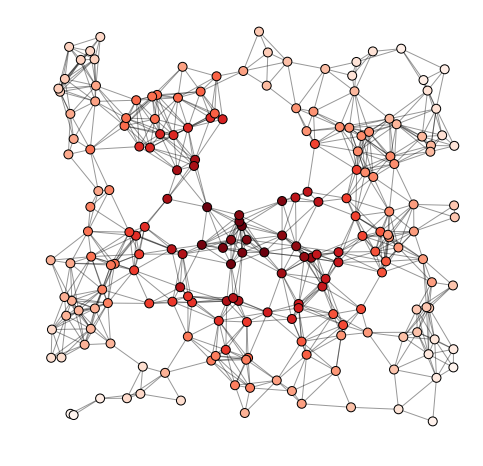

In [254]:
plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G,pos,nodelist=[ncenter],alpha=0.4)
nx.draw_networkx_nodes(G,pos,nodelist=list(p.keys()),
                       node_size=80,
                       node_color=spec,
                       edgecolors='black',
                       cmap=plt.cm.Reds_r)

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axis('off')
plt.show()

In [255]:
spec

array([2.12406696e-16, 1.05590962e-01, 1.41289191e-01, 2.21676708e-01,
       2.77267257e-01, 4.42063344e-01, 5.46160196e-01, 7.09763149e-01,
       8.11523571e-01, 8.56748722e-01, 1.13623625e+00, 1.22374105e+00,
       1.31464157e+00, 1.36807205e+00, 1.43693938e+00, 1.52874071e+00,
       1.98711335e+00, 2.18368848e+00, 2.24371573e+00, 2.26319348e+00,
       2.43307754e+00, 2.56347891e+00, 2.77844802e+00, 2.95218830e+00,
       3.00000000e+00, 3.10638002e+00, 3.13556650e+00, 3.31908626e+00,
       3.36676170e+00, 3.56052031e+00, 3.77428348e+00, 3.87080315e+00,
       3.93621944e+00, 4.00000000e+00, 4.08099578e+00, 4.24124555e+00,
       4.41191918e+00, 4.54438060e+00, 4.69633535e+00, 4.79455329e+00,
       4.83804294e+00, 4.98875082e+00, 5.00000000e+00, 5.06027520e+00,
       5.12555691e+00, 5.21856170e+00, 5.37165069e+00, 5.39219023e+00,
       5.57545513e+00, 5.67756547e+00, 5.81573015e+00, 5.88148360e+00,
       5.96769283e+00, 6.00000000e+00, 6.09014320e+00, 6.19421138e+00,
      

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


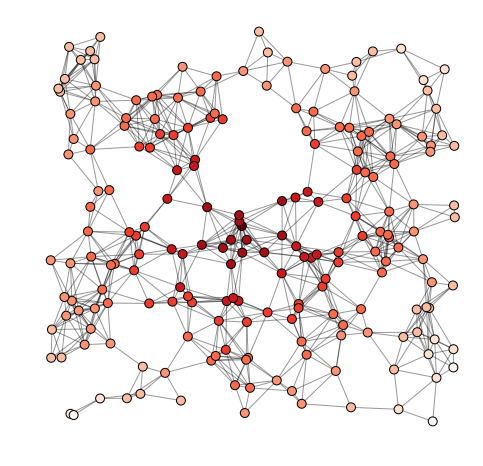

In [256]:
plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G,pos,nodelist=[ncenter],alpha=0.4)
nx.draw_networkx_nodes(G,pos,nodelist=list(p.keys()),
                       node_size=80,
                       node_color=list(p.values()),
                       edgecolors='black',
                       cmap=plt.cm.Reds_r)

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axis('off')
plt.show()

## Generate some visualizations for the liver

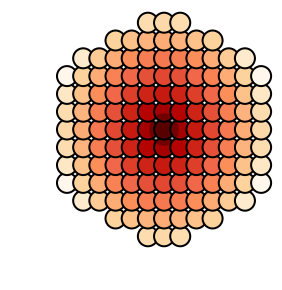

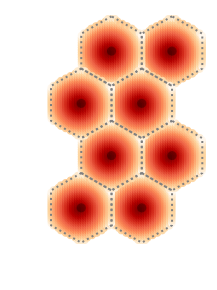

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from plot_utils import draw_liver_lobule
  
def save_figure(fn):
    plt.savefig(fn, bbox_inches='tight', transparent=True) 
    logger.info("Saved figure to: {}".format(fn))

def plot_liver_lobule(res="mid", fn=None):
    if res == "mid":
        fig, ax = plt.subplots(1, 1, figsize=(3,4.5))
        draw_liver_lobule(ax)
        ax.axis("off")
    if res == "high":
        fig, ax = plt.subplots(1, 1, figsize=(4,4.5))
        draw_liver_lobule(ax, single=True)
        ax.axis("off")
    if fn:
        save_figure(fn)
    else:
        plt.show()
plot_liver_lobule(res="high")
plot_liver_lobule(res="mid")

## Plot Toy Heatmap

[feat_viz INFO] [36]


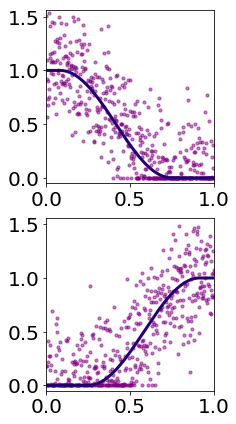

[feat_viz INFO] {'seed': 0, 'n_samps': 25, 'n_samps_list': [500, 1000, 1500, 2000, 5000], 'n_trials': 50, 'x_param': {'spike_grp': ['left', 'right'], 'n_repetitions': 3, 'rel_noise_list': [0.1]}, 'y_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r'], 'n_repetitions': 4, 'rel_noise_list': [0.05]}, 'target_vars': 36, 'method': None, 'graph_k': 10, 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_strict_1', 'n_var_list': [36]}


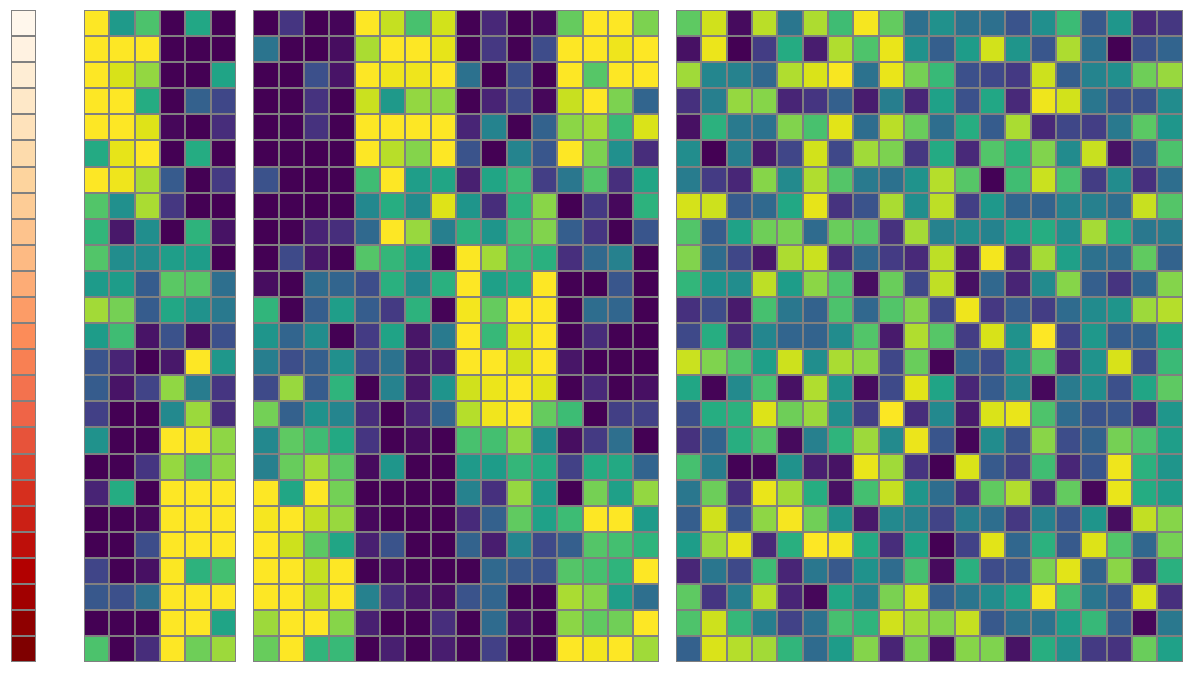

In [6]:


sim_params = get_sim_params("main_sim_strict_1")
sim_params["n_samps"] = 25
sim_params["y_param"]["n_repetitions"] = 4
sim_params["x_param"]['n_repetitions'] = 3
sim_params["x_param"]['rel_noise_list'] = [0.1]
sim_params["y_param"]['rel_noise_list'] = [5e-2]
sim_params["y_param"]['spike_grp'] = ['right', 'left', 'mid', 'mid_r']
sim_params['target_vars'] = 36
sim_params['n_var_list'] = [sim_params['target_vars']]
logger.info("{}".format(sim_params["n_var_list"]))

def plot_knowledge_anchors(sim_params, fn=None):
    nlist =  sim_params["x_param"]['rel_noise_list'] + [0]
    xspikes = sim_params["x_param"]['spike_grp']
    fig, ax = plt.subplots(2, 1, figsize=(3, 7))
    plot_spikes_examples(ax[0], xspikes[0], nlist)
    plot_spikes_examples(ax[1], xspikes[1], nlist)
    if fn:
        save_figure(fn)
    else:
        plt.show()
    return

def plot_example_heatmap(sim_params, fn=None):
    lam, x_mtx, y_mtx, n_mtx = generate_synthetic_data(sim_params, linspace=True, sort=True)
    l_mtx = np.expand_dims(lam, axis=1)
    fig = plt.figure(figsize=(21, 12))
    width_ratios = [l_mtx.shape[1],
                    l_mtx.shape[1]*0.5,
                    x_mtx.shape[1], 
                    y_mtx.shape[1], 
                    n_mtx.shape[1]]
    gs00 = gridspec.GridSpec(1, len(width_ratios), 
                            figure=fig,
                            width_ratios=width_ratios,
                            wspace=0.08, hspace=0.2)
    ax = plt.subplot(gs00[0, 0])
    ax = plot_base_heatmap(l_mtx, ax=ax, cmap="OrRd")
    ax = plt.subplot(gs00[0, 2])
    ax = plot_base_heatmap(x_mtx, ax=ax) 
    ax = plt.subplot(gs00[0, 3])
    ax = plot_base_heatmap(y_mtx, ax=ax) 
    ax = plt.subplot(gs00[0, 4])
    ax = plot_base_heatmap(n_mtx, ax=ax) 
    if fn:
        save_figure(fn)
    else:
        plt.show()
    return
    
plot_knowledge_anchors(sim_params)
plot_example_heatmap(sim_params)

## Save Figures to File

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_fig_liver_single.pdf
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_fig_liver.pdf
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_fig_predom.pdf
[feat_viz INFO] {'seed': 0, 'n_samps': 25, 'n_samps_list': [500, 1000, 1500, 2000, 5000], 'n_trials': 50, 'x_param': {'spike_grp': ['left', 'right'], 'n_repetitions': 3, 'rel_noise_list': [0.1]}, 'y_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r'], 'n_repetitions': 4, 'rel_noise_list': [0.05]}, 'target_vars': 36, 'method': None, 'graph_k': 10, 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_strict_1', 'n_var_list': [36]}
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_fig_mtx.pdf


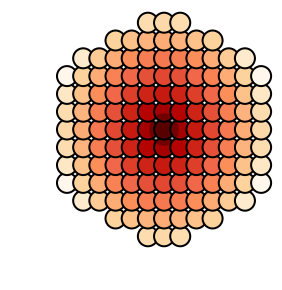

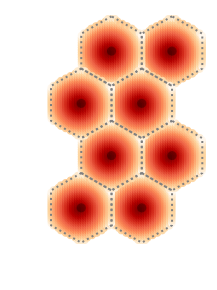

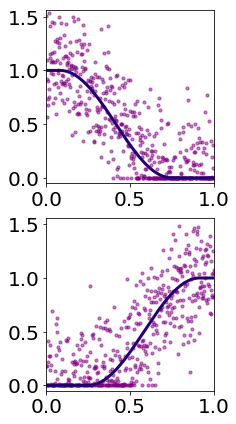

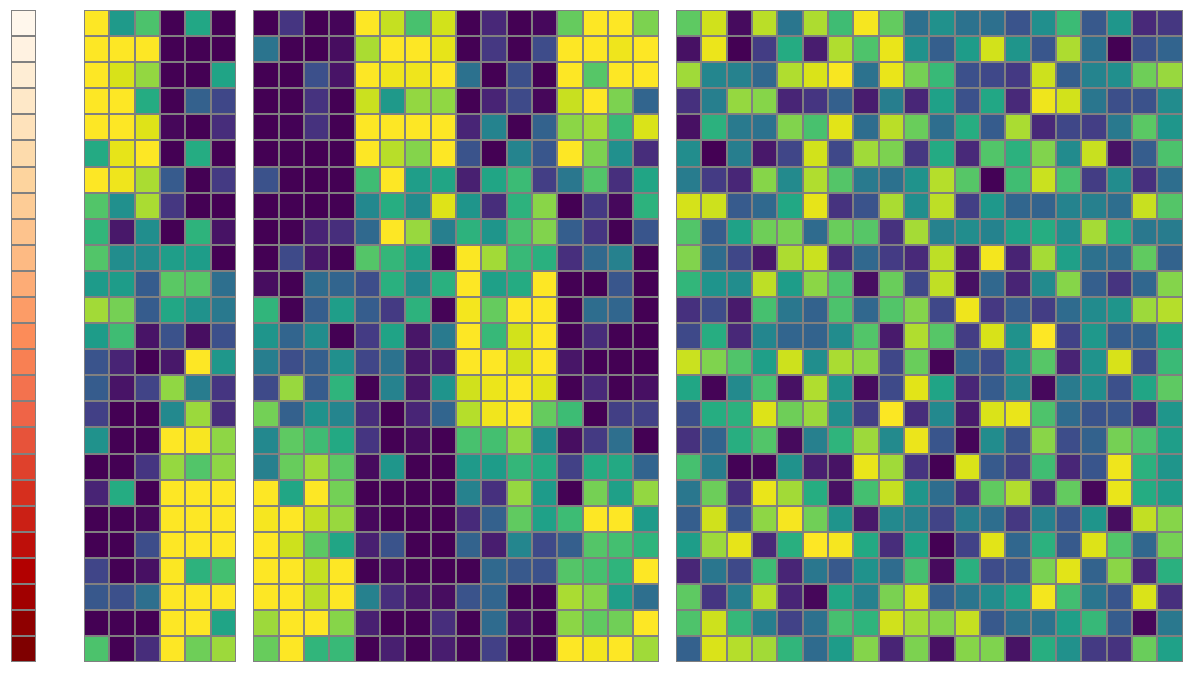

In [7]:
FDIR = "/share/PI/sabatti/feat_viz/main_figs"
fn = os.path.join(FDIR, "main_fig_liver_single.pdf")
plot_liver_lobule(res="high", fn=fn)
fn = os.path.join(FDIR, "main_fig_liver.pdf")
plot_liver_lobule(res="mid", fn=fn)
fn = os.path.join(FDIR, "main_fig_predom.pdf")
plot_knowledge_anchors(sim_params, fn=fn)
fn = os.path.join(FDIR, "main_fig_mtx.pdf")
plot_example_heatmap(sim_params, fn=fn)